## 1. Pré-processamento

O *dataset* original consistia em uma série temporal com **2.356.110 instâncias** e seis colunas principais (`date`, `state`, `name`, `code`, `cases`, `deaths`). Para atender aos objetivos de **aprendizado não supervisionado**, foi necessário transformar esses dados brutos em uma representação **descritiva e consolidada por município**.

#### Limpeza e Agregação dos Dados

Como cada município aparecia repetidamente ao longo do tempo, realizamos etapas de agregação para sintetizar seu perfil epidemiológico:

- **Tratamento dos dados:** remoção de valores nulos, registros em branco e colunas irrelevantes para a análise de *clusters*.
- **Engenharia de atributos (*feature engineering*):**
  - `total_cases`: total acumulado de casos por município.
  - `peak_cases`: maior número de casos registrados em um único dia, representando a intensidade do pico pandêmico local.

Essas transformações permitiram capturar tanto a magnitude quanto a dinâmica da disseminação da doença em cada localidade.

### Preparação para os Algoritmos de *Machine Learning*

Considerando que os algoritmos de *Machine Learning* operam exclusivamente sobre dados numéricos e são sensíveis à escala das variáveis, aplicamos as seguintes técnicas:

- **One-Hot Encoding:** conversão de variáveis categóricas em representações numéricas, possibilitando o seu uso nos modelos.
- **Normalização (`StandardScaler`):** padronização das variáveis numéricas.

#### &emsp; 1.1 Baixando o dataset

In [5]:
# Intalação do gdown para pegar .csv bruto
%pip install gdown


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Baixar o .csv bruto
!gdown --id "1sg9QK4g8QKCNgvfi6iNowcP75KNNkxUY" -O ./data/brazil_covid19_cities.csv

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sg9QK4g8QKCNgvfi6iNowcP75KNNkxUY
From (redirected): https://drive.google.com/uc?id=1sg9QK4g8QKCNgvfi6iNowcP75KNNkxUY&confirm=t&uuid=d84b7a9a-1d2f-4d7c-b90c-c032ced97b6b
To: /Users/douglasnunes/Desktop/github/project-unsupervised/Final/data/brazil_covid19_cities.csv
100%|████████████████████████████████████████| 106M/106M [00:03<00:00, 30.5MB/s]


In [7]:
# Importação do csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import umap
df = pd.read_csv('./data/brazil_covid19_cities.csv')

#### &emsp; 1.2 Modelando os dados 

In [8]:
# Renomear coluna name para city
df = df.rename(columns={'name': 'city'})

In [9]:
# Transforma a coluna `date` em um objeto DateTime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['city', 'date'])

In [10]:
# Garantir que casos e mortes são numéricos
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df['deaths'] = pd.to_numeric(df['deaths'], errors='coerce')

df = df.dropna(subset=['city', 'cases', 'deaths'])

In [11]:
# Adição de variáveis por cidade e estado
features_city = df.groupby(['city', 'state']).agg({
  'cases': ['max', 'mean', 'std'],
  'deaths': ['max', 'mean', 'std'],
  'date': 'count'
})

features_city.columns = [
  'total_cases',
  'mean_cases',
  'std_cases',
  'total_deaths',
  'mean_deaths',
  'std_deaths',
  'days_recorded'
]

features_city.head()

,,total_cases,mean_cases,std_cases,total_deaths,mean_deaths,std_deaths,days_recorded
city,state,,,,,,,
Abadia de Goiás,GO,1351.0,558.153664,426.181817,28,7.565012,7.530658,423
Abadia dos Dourados,MG,375.0,118.761229,119.465862,14,2.687943,4.138253,423
Abadiânia,GO,400.0,147.659574,105.898626,27,10.801418,8.029761,423
Abaetetuba,PA,7659.0,3646.444444,2098.725146,210,104.628842,48.581654,423
Abaeté,MG,1019.0,248.574468,312.806079,26,5.224586,6.855251,423


In [12]:
# Adição de coluna `death_rate` (taxa de mortalidade)
features_city['death_rate'] = (
    features_city['total_deaths'] / features_city['total_cases']
)


In [13]:
# Crescimento dos casos
df['new_cases'] = df.groupby(['city', 'state'])['cases'].diff().fillna(0)

growth = df.groupby(['city', 'state'])['new_cases'].mean().rename('mean_daily_growth')
features_city = features_city.join(growth)

In [14]:
# Dia do primeiro caso
first_case = df[df['cases'] > 0].groupby(['city','state'])['date'].min()
first_case = (first_case - df['date'].min()).dt.days
first_case = first_case.rename('days_until_first_case')

features_city = features_city.join(first_case)

In [15]:
# Remoção de registros com dados faltosos
features_city = features_city.dropna()

In [16]:
# Reset de índices
features_city = features_city.reset_index()

In [17]:
# Remoção do do campo `city`
features_city.drop('city', axis=1, inplace=True)

In [18]:
# Aplicando one-hot encode no campo `state`
features_city = pd.get_dummies(features_city, columns=['state'])

In [19]:
# Finalização do DataFrame tratado
df = features_city.copy()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_cases            5570 non-null   float64
 1   mean_cases             5570 non-null   float64
 2   std_cases              5570 non-null   float64
 3   total_deaths           5570 non-null   int64  
 4   mean_deaths            5570 non-null   float64
 5   std_deaths             5570 non-null   float64
 6   days_recorded          5570 non-null   int64  
 7   death_rate             5570 non-null   float64
 8   mean_daily_growth      5570 non-null   float64
 9   days_until_first_case  5570 non-null   int64  
 10  state_AC               5570 non-null   bool   
 11  state_AL               5570 non-null   bool   
 12  state_AM               5570 non-null   bool   
 13  state_AP               5570 non-null   bool   
 14  state_BA               5570 non-null   bool   
 15  stat

## Estruturação dos Dados pós-processamento

Após as etapas de limpeza, o conjunto de dados consolidado passou a contar com 5.570 instâncias. Isso representa a totalidade dos municípios brasileiros e 37 colunas estruturadas.

| Categoria                          | Métrica / Atributo           | Descrição                                                                 |
|-----------------------------------|------------------------------|---------------------------------------------------------------------------|
| **Magnitude e Dispersão**          | `total_cases`                | Total acumulado de casos por município.                                   |
|                                   | `mean_cases`                 | Média diária de casos registrados ao longo do período analisado.          |
|                                   | `std_cases`                  | Desvio padrão dos casos diários, indicando a variabilidade do contágio.   |
|                                   | `total_deaths`               | Total acumulado de óbitos por município.                                  |
|                                   | `mean_deaths`                | Média diária de óbitos registrados no período.                             |
| **Indicadores Epidemiológicos**    | `death_rate`                 | Taxa de letalidade por município (óbitos / casos confirmados).            |
| **Avançados**                     | `mean_daily_growth`          | Velocidade média de crescimento diário dos casos.                          |
|                                   | `days_until_first_case`      | Número de dias até o registro do primeiro caso no município.               |
| **Localização Geográfica**         | `state_AC` – `state_TO`      | Variáveis binárias geradas por One-Hot Encoding para representar os estados |
|                                   |                              | brasileiros, permitindo capturar regionalidade sem ordem numérica.        |


## Normalização

In [21]:
# Normalização
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

## 2. Redução de Dimensionalidade


#### &emsp; 2.1 Aplicação de PCA

In [32]:
# Inicializando a PCA 
pca_full = PCA()
pca_full.fit(df_scaled)

pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(df_scaled)

# Calculando a variancia explicada acumulada
variancia_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

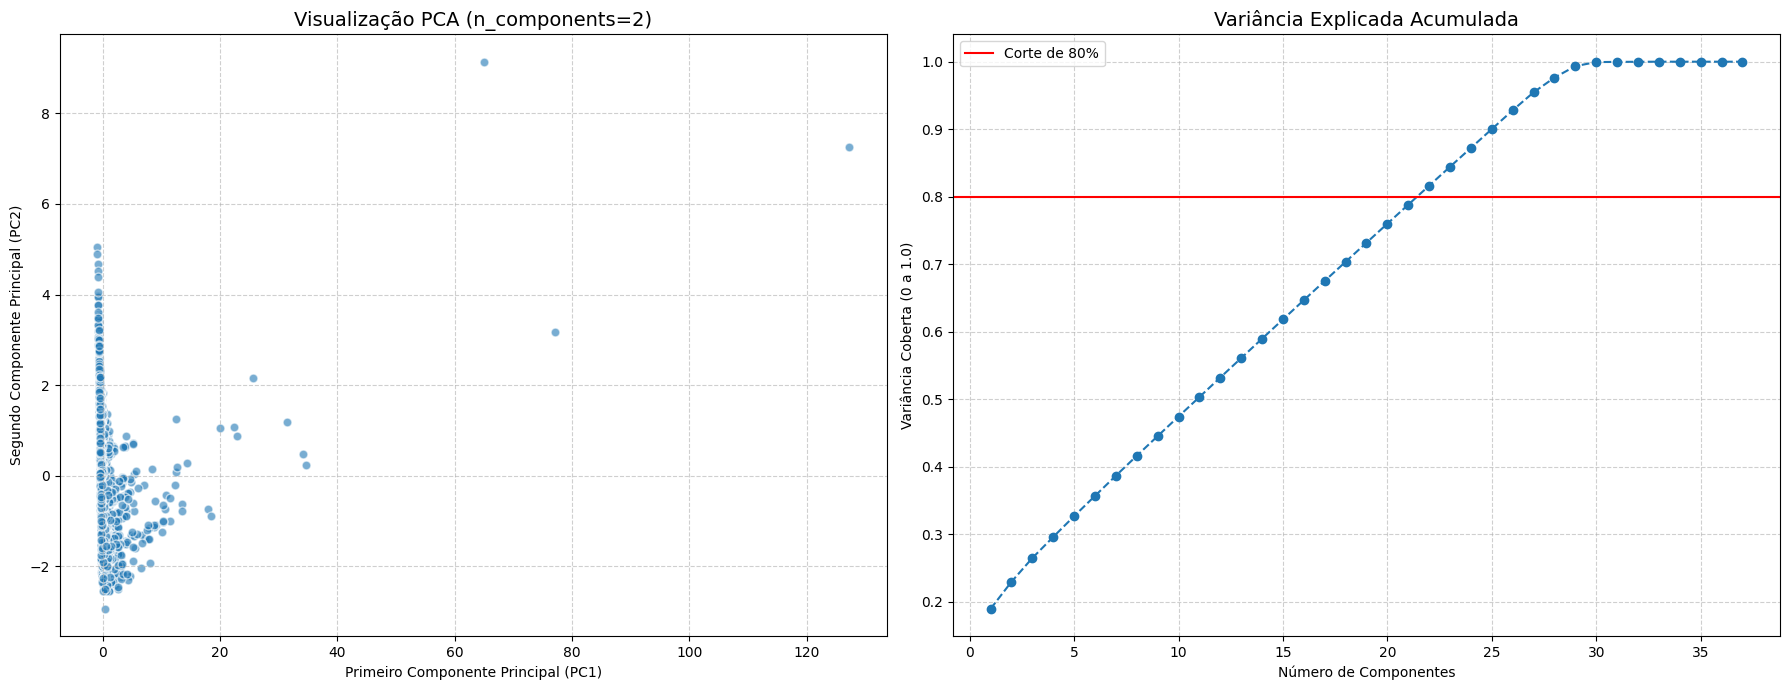

Variância Total com 2 componentes: 22.93%


In [33]:
# Criando a moldura com 1 linha e 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Visualização PCA 
ax1.scatter(df_scaled_pca[:, 0], df_scaled_pca[:, 1], alpha=0.6, edgecolors='w', s=40)
ax1.set_title('Visualização PCA (n_components=2)', fontsize=14)
ax1.set_xlabel('Primeiro Componente Principal (PC1)')
ax1.set_ylabel('Segundo Componente Principal (PC2)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Vizualização da Variância
ax2.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
ax2.axhline(y=0.80, color='r', linestyle='-', label='Corte de 80%') # Linha de corte
ax2.set_title('Variância Explicada Acumulada', fontsize=14)
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Variância Coberta (0 a 1.0)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout para não sobrepor
plt.tight_layout()
plt.show()

# Print informativo
print(f"Variância Total com 2 componentes: {variancia_acumulada[1]:.2%}")

#### &emsp;  2.2 Aplicação de t-SNE

#### &emsp;  2.3 Aplicação de UMAP

## 3. Clusterização

#### &emsp;  3.1 Aplicação de K-Means

#### &emsp;  3.2 Aplicação de DBSCAN

## 4. Discussão de resultados